# Exploratory analysis for NDVI in South America

 - Original data spatial resolution as well as regridded data in order to fit ERA-INTERIM grid.
 - Monthly means maps.
 - Standard deviation.
 - Seasonal means maps.
 - Empirical orthogonal functions analysis for regridded data.

## Initial setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings 

In [3]:
warnings.filterwarnings("ignore")

In [4]:
# Load packages
import sys
import glob
import calendar
import itertools

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from cartopy import crs as ccrs
from cartopy import feature as cfeature
from dask.diagnostics import ProgressBar
from cartopy.io import shapereader
from eofs.xarray import Eof
from sklearn.metrics import r2_score

import numpy as np
import xarray as xr
import pandas as pd

%matplotlib inline

In [5]:
print(">>> Version of xarray:", xr.__version__)                                                    

>>> Version of xarray: 0.12.1


In [6]:
# My repository.
repository = "/home/alex/Dropbox/repositories/climate_vegetation/libraries/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn

# Map borders.
loni, lonf, lati, latf = -90, -30, 20, -60

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/climate_vegetation/images/"

In [7]:
# Folder with data.
DATA_FOLDER = "/media/alex/ALEXDATA/data_sets/GIMMS/NDVI/"

## Load data

In [8]:
# Including regridded.
ALL_FILES_PATHS = sorted(glob.glob(DATA_FOLDER + "*.nc4"))

FILES_PATHS_ORIGINAL = []
FILES_PATHS_REGRIDDED = []
for FILE_PATH in ALL_FILES_PATHS:

    # Excluding regridded.
    if "regridded" not in FILE_PATH:
        FILES_PATHS_ORIGINAL.append(FILE_PATH)

    # Only spatial regridded data    
    else:                    
        FILES_PATHS_REGRIDDED.append(FILE_PATH)

In [9]:
%%time

# Lazy read of global data sets.
DSo = xr.open_mfdataset(FILES_PATHS_ORIGINAL, concat_dim="time")
DSr = xr.open_mfdataset(FILES_PATHS_REGRIDDED, concat_dim="time")

# South America.
DSo = DSo.sel(lon=slice(loni, lonf), lat=slice(lati, latf))
DSr = DSr.sel(longitude=slice(loni, lonf), latitude=slice(lati, latf))

CPU times: user 981 ms, sys: 52.9 ms, total: 1.03 s
Wall time: 1.09 s


In [10]:
DSo

<xarray.Dataset>
Dimensions:     (lat: 960, lon: 720, time: 828)
Coordinates:
  * lon         (lon) float64 -89.96 -89.88 -89.79 ... -30.21 -30.13 -30.04
  * lat         (lat) float64 19.96 19.88 19.79 19.71 ... -59.79 -59.88 -59.96
  * time        (time) float64 7.0 7.5 8.0 8.5 9.0 ... 10.5 11.0 11.5 12.0 12.5
Data variables:
    satellites  (time) int16 dask.array<shape=(828,), chunksize=(12,)>
    ndvi        (time, lat, lon) float32 dask.array<shape=(828, 960, 720), chunksize=(12, 960, 720)>
    percentile  (time, lat, lon) int16 dask.array<shape=(828, 960, 720), chunksize=(12, 960, 720)>
Attributes:
    FileName:              ndvi3g_geo_v1_1981_0712.nc4
    Institution:           NASA/GSFC GIMMS
    Data:                  NDVI3g version 1
    Reference:             1. Pinzon, J.E.; Tucker, C.J.                     ...
    CommentsVersion1:      version1 includes two major fixes (a and b), and t...
    Temporalrange:         1981-07-01 -> 2015-12-31
    Year:                  1981.

In [11]:
DSr

<xarray.Dataset>
Dimensions:    (latitude: 107, longitude: 81, time: 828)
Coordinates:
  * longitude  (longitude) float64 -90.0 -89.25 -88.5 ... -31.5 -30.75 -30.0
  * latitude   (latitude) float64 19.5 18.75 18.0 17.25 ... -58.5 -59.25 -60.0
  * time       (time) float64 7.0 7.5 8.0 8.5 9.0 ... 10.5 11.0 11.5 12.0 12.5
Data variables:
    ndvi       (time, latitude, longitude) float64 dask.array<shape=(828, 107, 81), chunksize=(12, 107, 81)>

**DANGER ZONE:** LOAD DATA INTO MEMORY!

In [12]:
# Xarray DataArray object for NDVI.
DAo = DSo.ndvi
DAr = DSr.ndvi

In [13]:
# Load into memory.
with ProgressBar():
    DAo = DAo.compute()

[########################################] | 100% Completed |  1min 35.7s


In [14]:
# Load into memory.
with ProgressBar():
    DAr = DAr.compute()

[########################################] | 100% Completed | 16.7s


## Preprocess data

In [15]:
# Scale factor and valid range of data [-0.3, 1.0].
DAo = DAo / 1e4
DAo = DAo.where(cond=(DAo > -0.3), other=-0.3)
DAo = DAo.where(cond=(DAo < 1.0), other=1.0)

# Make time coordinate as datetime.
DAo["time"] = pd.date_range(start="1981-07-01", end="2015-12-31", periods=DAo.time.size)

In [16]:
# Scale factor and valid range of data [-0.3, 1.0].
DAr = DAr / 1e4
DAr = DAr.where(cond=(DAr > -0.3), other=-0.3)
DAr = DAr.where(cond=(DAr < 1.0), other=1.0)

# Make time coordinate as datetime.
DAr["time"] = pd.date_range(start="1981-07-01", end="2015-12-31", periods=DAr.time.size)

In [17]:
# Only land pixels at ERA-INTERIM grid.
DAr = cdlearn.pixels.EraInterimGrid.add_land_mask(DAr)
DAr = DAr.where(DAr.land_mask == True)

## Monthly means maps

In [18]:
# First we will use cartopy's shapereader to download (and cache) states shapefile with 50 meters
# resolution from the NaturalEarth.
kw = dict(resolution="50m", category="cultural", name="admin_1_states_provinces")

states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

In [19]:
# Monthly means.
DAo_mm = DAo.groupby("time.month").mean("time")
DAr_mm = DAr.groupby("time.month").mean("time")

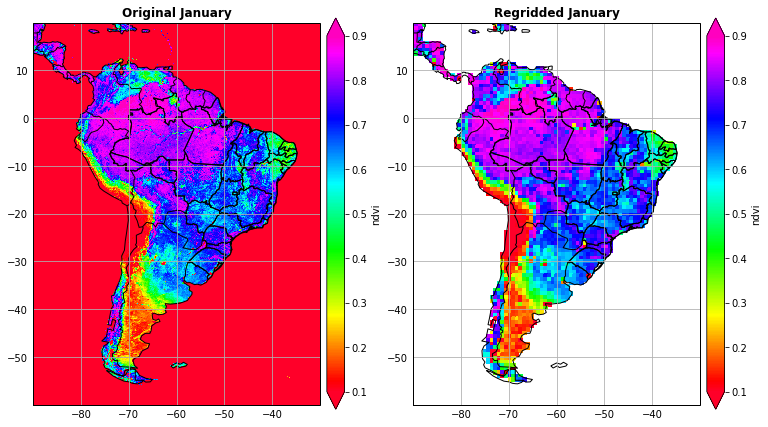

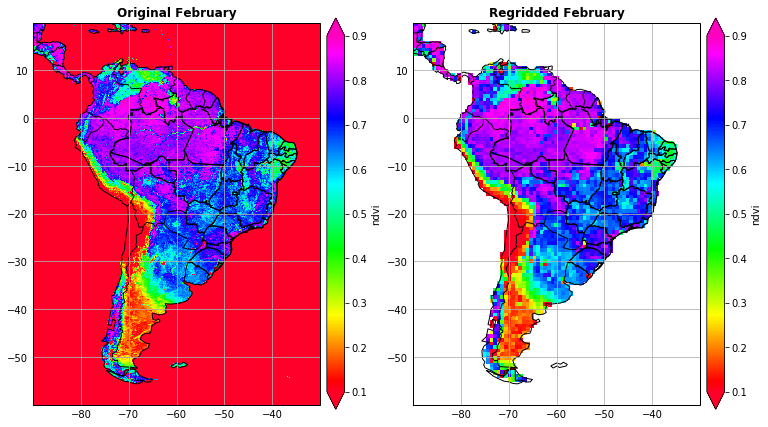

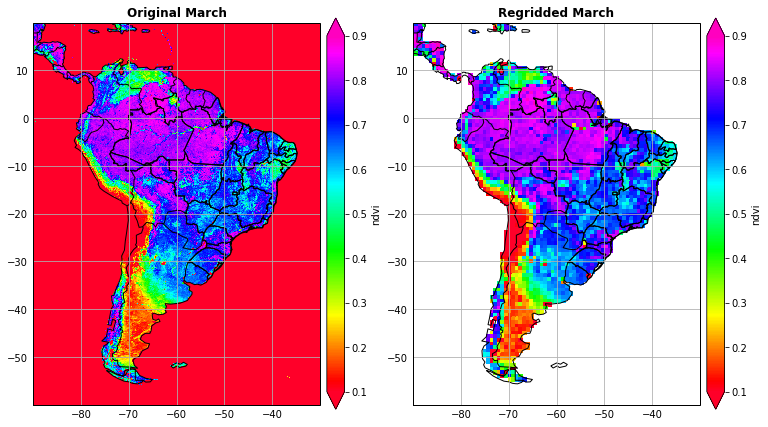

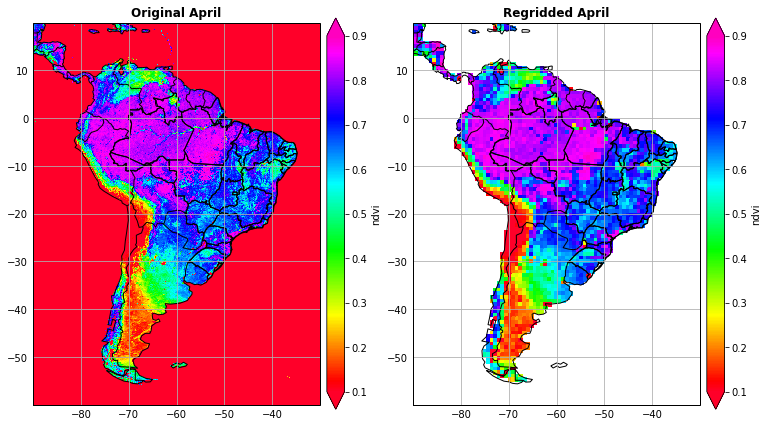

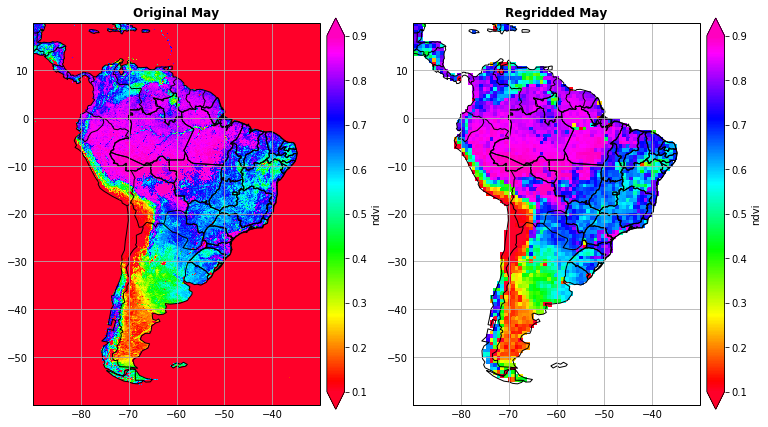

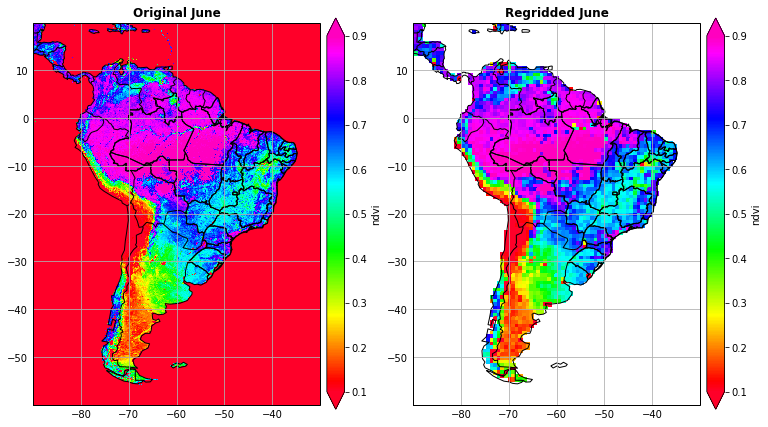

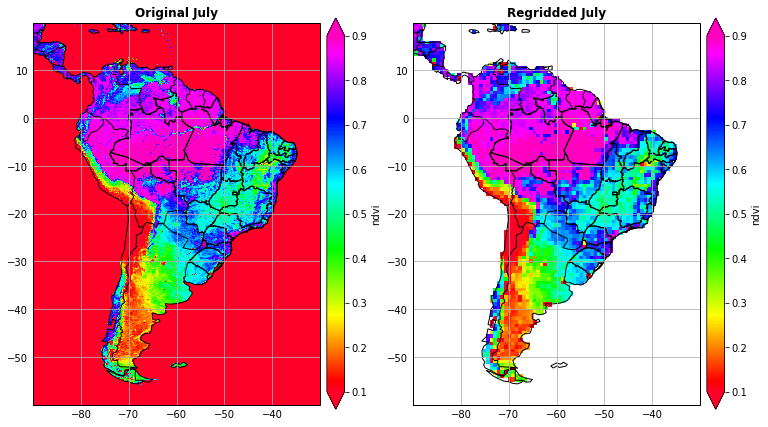

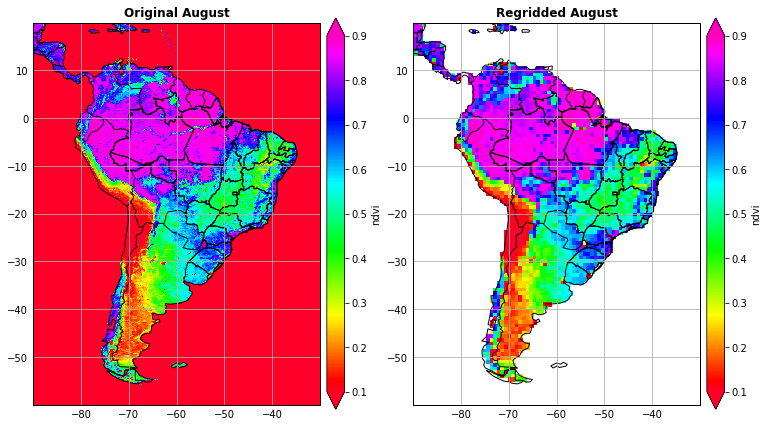

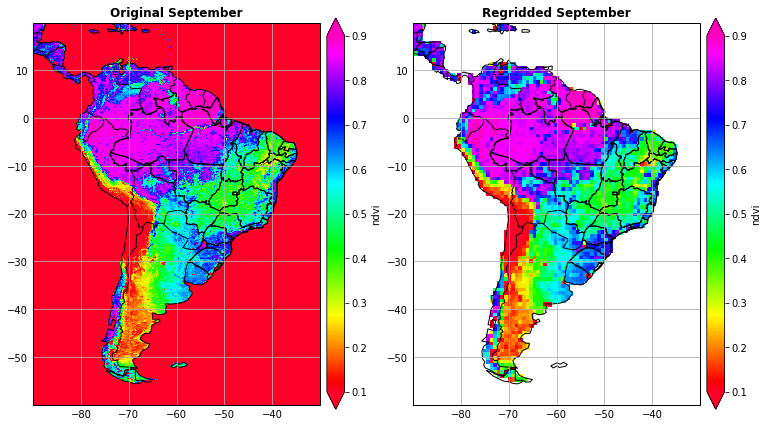

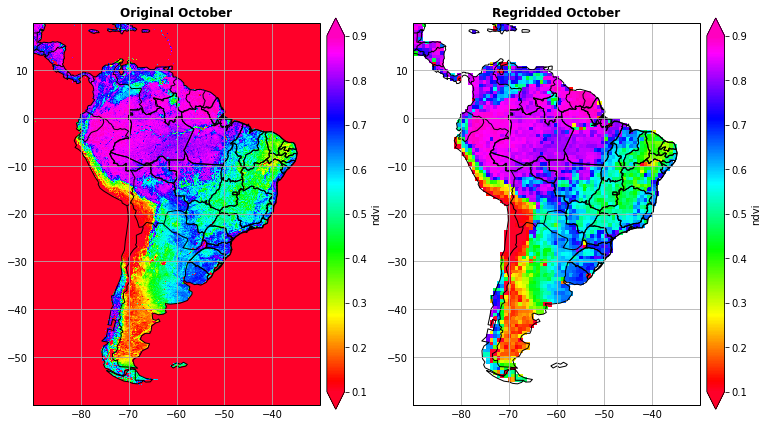

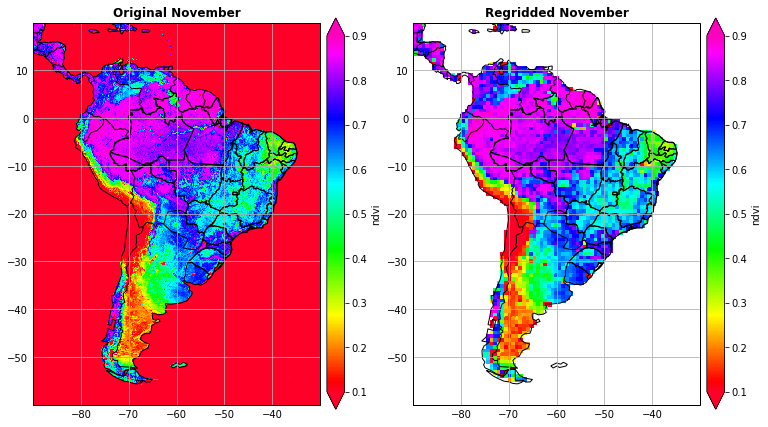

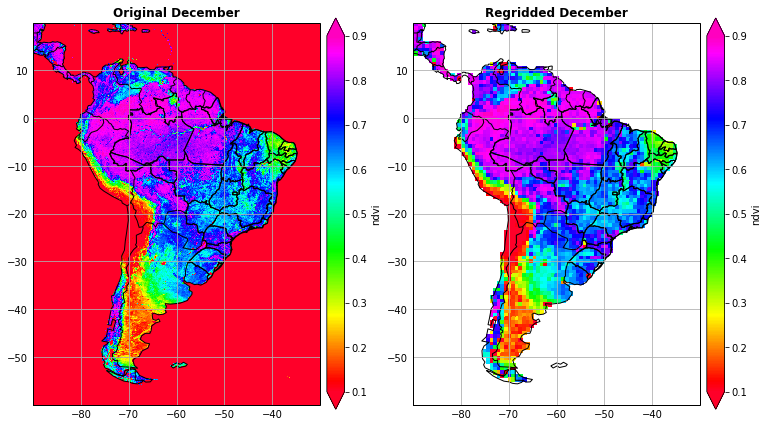

In [20]:
# Plot monthly means.
for month in range(1, 13):
    
    # Make maps.
    plt.figure(figsize=(13, 9))
    
    # Plot on the right side.
    ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
    ax1.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
    ax1.add_feature(cfeature.BORDERS)
    ax1.coastlines()
    gl1 = ax1.gridlines(draw_labels=True)
    gl1.xlabels_top = False
    gl1.ylabels_right = False
            
    map1 = DAo_mm.sel(month=month).plot(ax=ax1, 
                                        vmin=0.1, vmax=0.9,
                                        cmap=plt.cm.gist_rainbow, 
                                        cbar_kwargs={"shrink": 0.80,
                                                     "pad": 0.020,
                                                     "extend": "both"})
    ax1.set_title("Original " + calendar.month_name[month], weight="bold")
    
    # Plot on the right side.
    ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
    ax2.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
    ax2.add_feature(cfeature.BORDERS)
    ax2.coastlines()
    gl2 = ax2.gridlines(draw_labels=True)
    gl2.xlabels_top = False
    gl2.ylabels_right = False
    map2 = DAr_mm.sel(month=month).plot(ax=ax2, 
                                        vmin=0.1, vmax=0.9,
                                        cmap=plt.cm.gist_rainbow, 
                                        cbar_kwargs={"shrink": 0.80,
                                                     "pad": 0.020,
                                                     "extend": "both"})
    ax2.set_title("Regridded " + calendar.month_name[month], weight="bold")
    
    # Minor adjustment.
    plt.subplots_adjust(wspace=0.1);
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        ax1.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")
        ax2.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")

In [21]:
# Extract data as numpy arrays.
DATA = DAr_mm.values
LON, LAT = np.meshgrid(DAr_mm.longitude, DAr_mm.latitude)

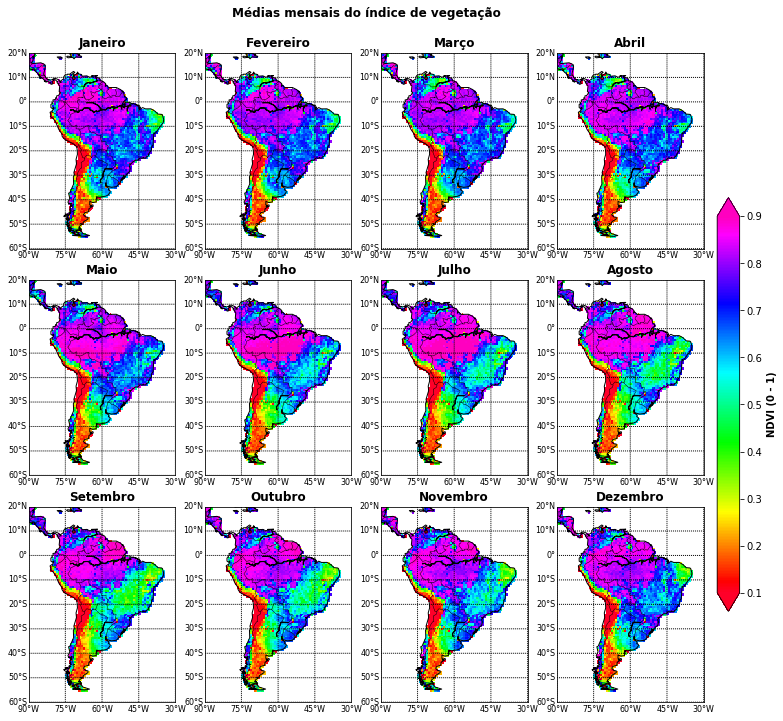

In [22]:
# Make figure.
cdlearn.maps.regional_scalar_monthly_means(DATA, LON, LAT, loni, lonf, lati, latf, 
                                           clim=(0.1, 0.9), cmap=plt.cm.gist_rainbow, 
                                           months_labels=cdlearn.utils.months_labels_pt,
                                           title="Médias mensais do índice de vegetação",
                                           clabel="NDVI (0 - 1)",
                                           fig_size=(12.5, 11.5), save_fig=False,
                                           fig_path=fig_path, fig_name="ndvi_mmeans_pt")

## Mean map 

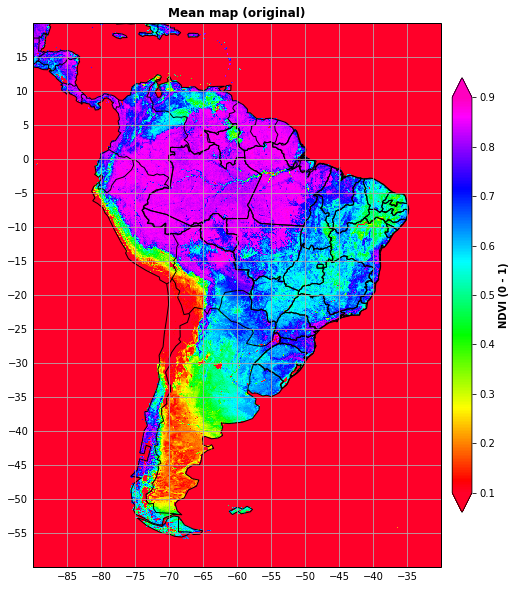

In [23]:
# Make figure.
plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
gl = ax.gridlines(draw_labels=True, xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))
gl.xlabels_top = False
gl.ylabels_right = False
MAP = DAo.mean("time").plot(ax=ax, vmin=0.1, vmax=0.9, cmap=plt.cm.gist_rainbow, 
                            cbar_kwargs={"shrink": 0.80,
                                         "pad": 0.020,
                                         "extend": "both"})
MAP.colorbar.set_label("NDVI (0 - 1)", weight="bold")
ax.set_title("Mean map (original)", weight="bold")

# Brazilian states's boundaries.
for state in shp.geometries():
    ax.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")

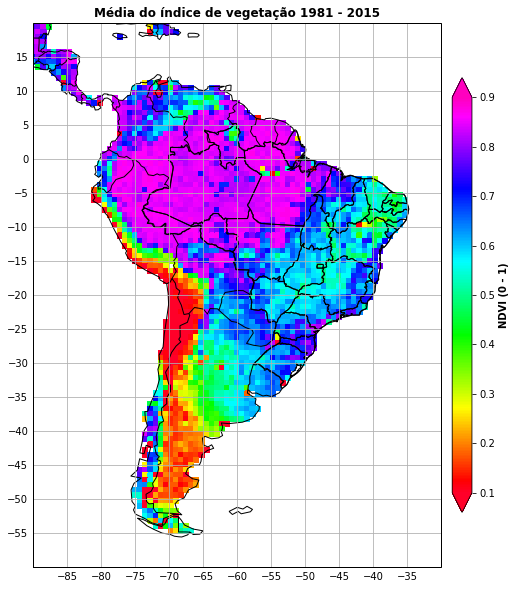

In [24]:
# Make figure.
plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
gl = ax.gridlines(draw_labels=True, xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))
gl.xlabels_top = False
gl.ylabels_right = False
MAP = DAr.mean("time").plot(ax=ax, vmin=0.1, vmax=0.9, cmap=plt.cm.gist_rainbow, 
                            cbar_kwargs={"shrink": 0.80,
                                         "pad": 0.020,
                                         "extend": "both"})
MAP.colorbar.set_label("NDVI (0 - 1)", weight="bold")
ax.set_title("Média do índice de vegetação 1981 - 2015", weight="bold")

# Brazilian states's boundaries.
for state in shp.geometries():
    ax.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")

# Save figure.
# plt.savefig(fig_path + "ndvi_mean_pt.jpg", dpi=200, bbox_inches="tight")

## Standard deviation

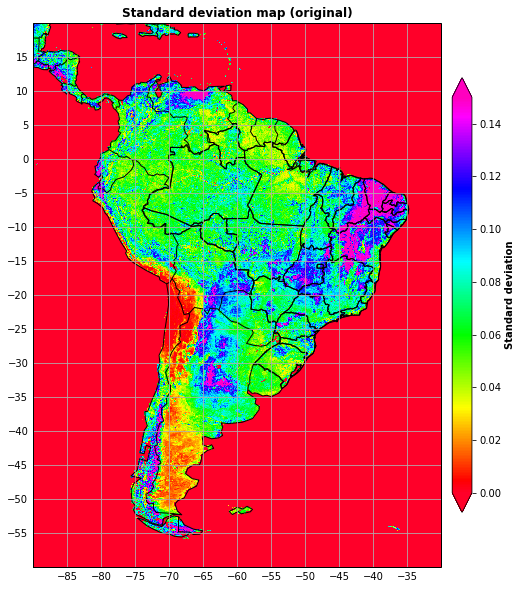

In [25]:
# Make figure.
plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
gl = ax.gridlines(draw_labels=True, xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))
gl.xlabels_top = False
gl.ylabels_right = False
MAP = DAo.std("time").plot(ax=ax, vmin=0.00, vmax=0.15, cmap=plt.cm.gist_rainbow, 
                           cbar_kwargs={"shrink": 0.80,
                                        "pad": 0.020,
                                        "extend": "both"})
MAP.colorbar.set_label("Standard deviation", weight="bold")
ax.set_title("Standard deviation map (original)", weight="bold")

# Brazilian states's boundaries.
for state in shp.geometries():
    ax.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")

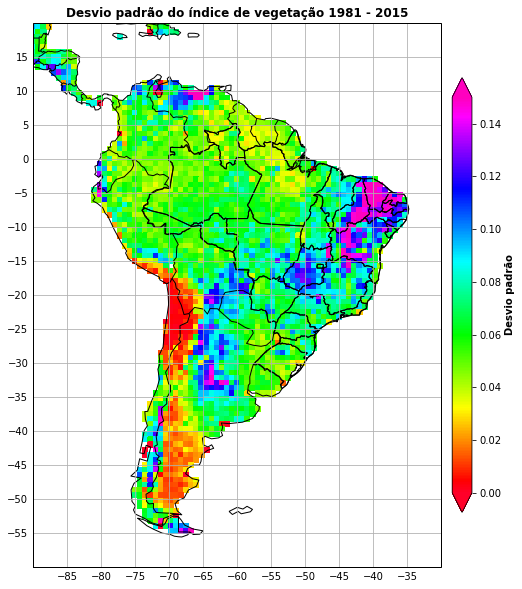

In [26]:
# Make figure.
plt.figure(figsize=(10, 10))

ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
gl = ax.gridlines(draw_labels=True, xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))
gl.xlabels_top = False
gl.ylabels_right = False
MAP = DAr.std("time").plot(ax=ax, vmin=0.00, vmax=0.15, cmap=plt.cm.gist_rainbow, 
                            cbar_kwargs={"shrink": 0.80,
                                         "pad": 0.020,
                                         "extend": "both"})
MAP.colorbar.set_label("Desvio padrão", weight="bold")
ax.set_title("Desvio padrão do índice de vegetação 1981 - 2015", weight="bold")

# Brazilian states's boundaries.
for state in shp.geometries():
    ax.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")

# Save figure.
# plt.savefig(fig_path + "ndvi_std_pt.jpg", dpi=200, bbox_inches="tight")

## Seasonal means maps

In [27]:
# Seasonal means.
DAo_se = DAo.groupby("time.season").mean("time")
DAr_se = DAr.groupby("time.season").mean("time")

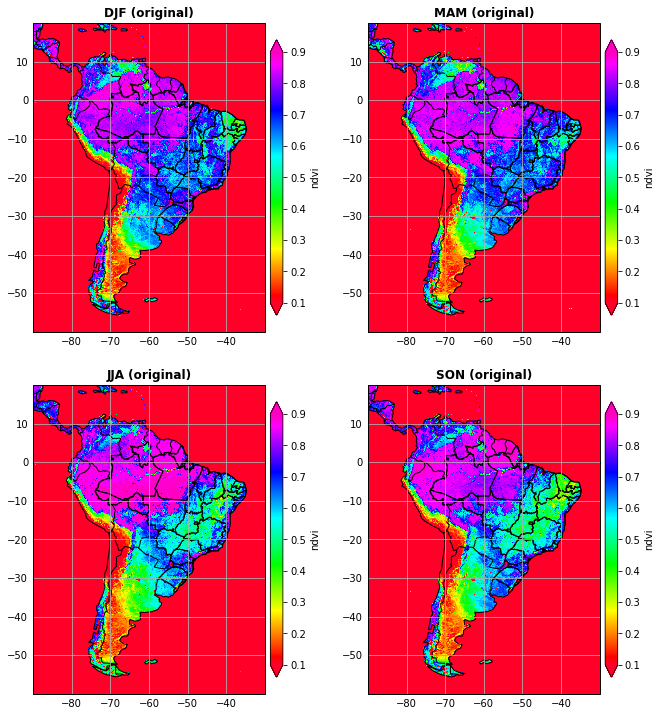

In [28]:
# Make figure.
plt.figure(figsize=(11, 13))

# Counter.
c = itertools.count(start=0, step=1)

# Seasons.
seasons=["DJF", "MAM", "JJA", "SON"]

# One map for each season.
for i in range(1, 5):

    season = seasons[next(c)]
    ax = plt.subplot(2, 2, i, projection=ccrs.PlateCarree())
    ax.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    DAo_se.sel(season=season).plot(ax=ax, 
                                   vmin=0.1, vmax=0.9,
                                   cmap=plt.cm.gist_rainbow, 
                                   cbar_kwargs={"shrink": 0.80,
                                                "pad": 0.020,
                                                "extend": "both"})
    ax.set_title(season + " (original)", weight="bold")
    plt.subplots_adjust(hspace=0.05)
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        ax.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")

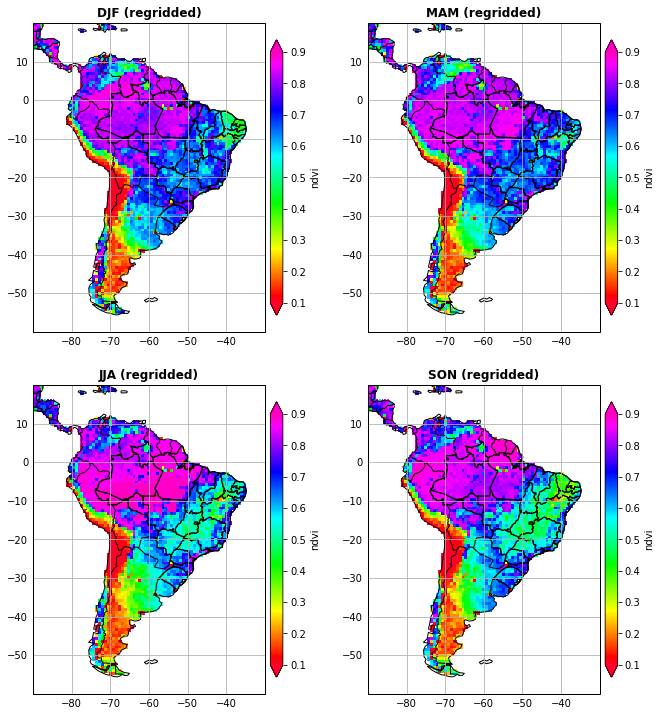

In [29]:
# Make figure.
plt.figure(figsize=(11, 13))

# Counter.
c = itertools.count(start=0, step=1)

# Seasons.
seasons=["DJF", "MAM", "JJA", "SON"]

# One map for each season.
for i in range(1, 5):

    season = seasons[next(c)]
    ax = plt.subplot(2, 2, i, projection=ccrs.PlateCarree())
    ax.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    DAr_se.sel(season=season).plot(ax=ax, 
                                   vmin=0.1, vmax=0.9,
                                   cmap=plt.cm.gist_rainbow, 
                                   cbar_kwargs={"shrink": 0.80,
                                                "pad": 0.020,
                                                "extend": "both"})
    ax.set_title(season + " (regridded)", weight="bold")
    plt.subplots_adjust(hspace=0.05)
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        ax.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")

## Empirical orthogonal functions analysis for regridded data

In [30]:
# Preprocess regridded data at monthly time scale for EOF.
# First resample data at monthly scale. Then set as not a number the sea pixels.
DAr_mm_ts = DAr.resample({"time": "1MS"}).mean("time")
DAr_mm_ts = DAr_mm_ts.where(cond=DAr_mm_ts.mean("time") >= 0, other=np.nan)

In [31]:
# Create an EOF solver to do the EOF analysis.
solver = Eof(DAr_mm_ts)

In [32]:
# Retrieve EOFs, principal component time series, and fraction of explained variance as xarray 
# DataArary objects for all components.
EOFs = solver.eofs()
PCs = solver.pcs() 
PCTs = solver.varianceFraction()

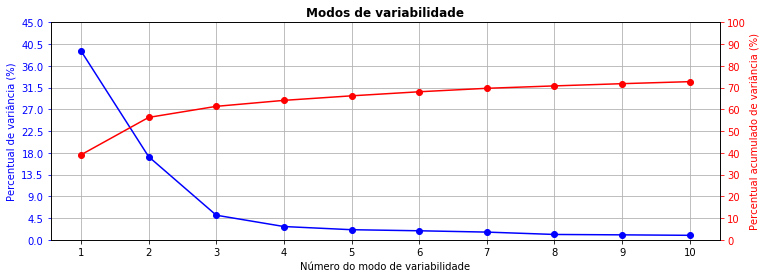

In [33]:
# Percentual of variance for N of the first modes.
N = 10
M = range(1, N + 1)
plt.figure(figsize=(12, 4))
plt.plot(M, PCTs.values[:N] * 100, "o-b")
plt.xlabel("Número do modo de variabilidade")
plt.ylabel("Percentual de variância (%)", color="blue")
plt.title("Modos de variabilidade", weight="bold")
plt.xticks(M)
ax1 = plt.gca()
ax2 = ax1.twinx()
ax1.set_ylim((0, 45))
ax2.set_ylim((0, 100))
ax2.plot(M, np.cumsum(PCTs.values[:N] * 100), "o-r")
ax2.set_ylabel("Percentual acumulado de variância (%)", color="red")
ax1.tick_params(axis="y", colors="blue")
ax2.tick_params(axis="y", colors="red")
ax1.set_yticks(np.linspace(0, ax1.get_yticks()[-1], 11))
ax2.set_yticks(np.linspace(0, ax2.get_yticks()[-1], len(ax1.get_yticks())))
ax1.grid();
# plt.savefig(fig_path + "ndvi_modes_variances_pt.jpg", dpi=200, bbox_inches="tight")

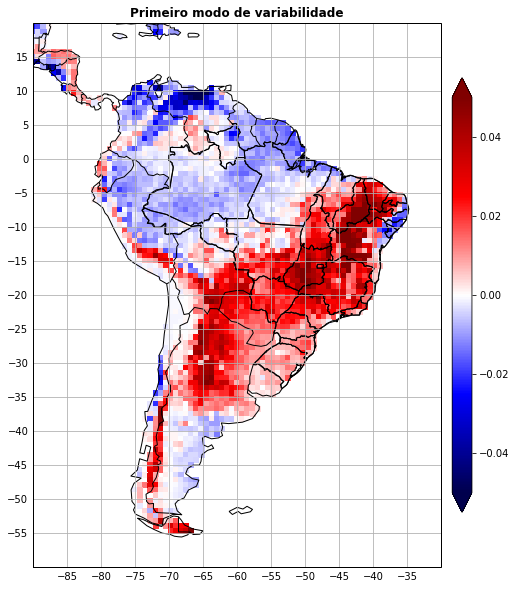

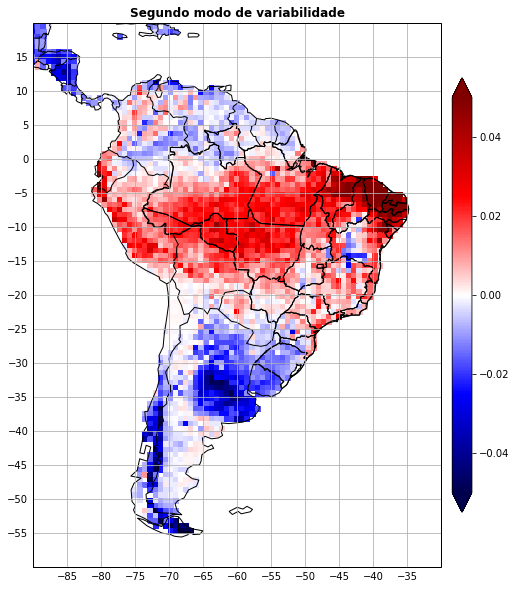

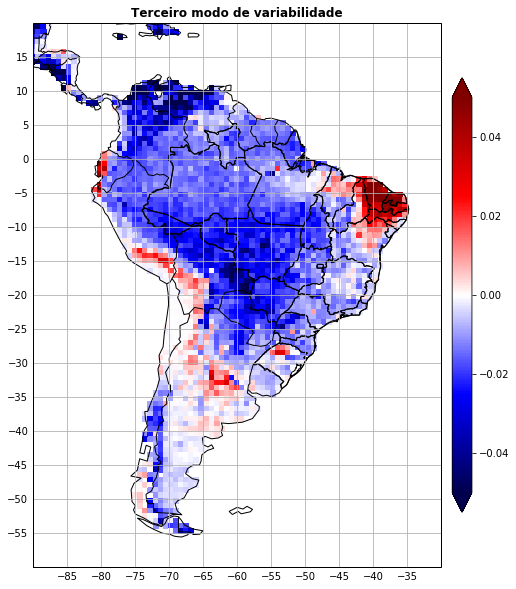

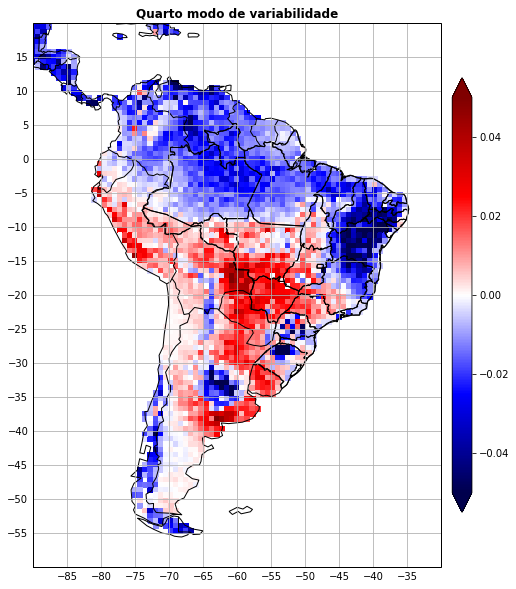

In [34]:
# Plot some modes.
for mode, order, clim in zip(range(4), 
                             ["Primeiro", "Segundo", "Terceiro", "Quarto"], 
                             [(-0.05, 0.05), (-0.05, 0.05), (-0.05, 0.05), (-0.05, 0.05)]):

    # Make figure.
    plt.figure(figsize=(10, 10))

    ax = plt.subplot(1, 1, 1, projection=ccrs.PlateCarree())
    ax.set_extent([loni, lonf, latf, lati], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    gl = ax.gridlines(draw_labels=True, xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))
    gl.xlabels_top = False
    gl.ylabels_right = False
    MAP = EOFs.sel(mode=mode).plot(ax=ax, vmin=clim[0], vmax=clim[1], cmap=plt.cm.seismic, 
                                   cbar_kwargs={"shrink": 0.80,
                                                "pad": 0.020,
                                                "extend": "both"})
    MAP.colorbar.set_label("", weight="bold")
    ax.set_title(order + " modo de variabilidade", weight="bold")

    # Brazilian states's boundaries.
    for state in shp.geometries():
        ax.add_geometries([state], ccrs.PlateCarree(), facecolor="none", edgecolor="black")

    # Save figure.
#     plt.savefig(fig_path + "ndvi_mode" + str(mode + 1) + "_eof_pt.jpg", dpi=200, 
#                 bbox_inches="tight")

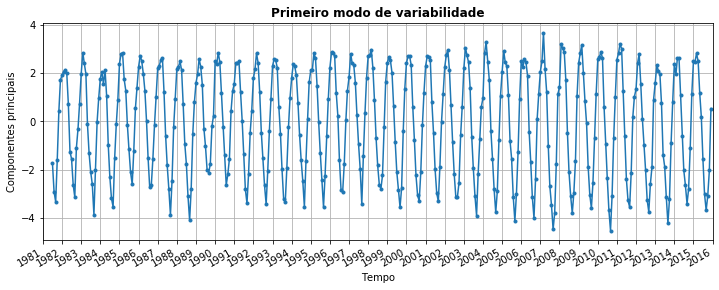

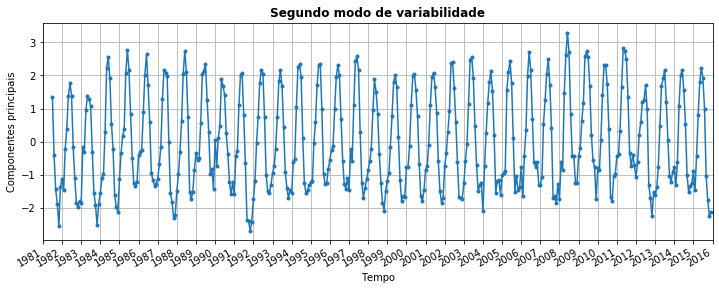

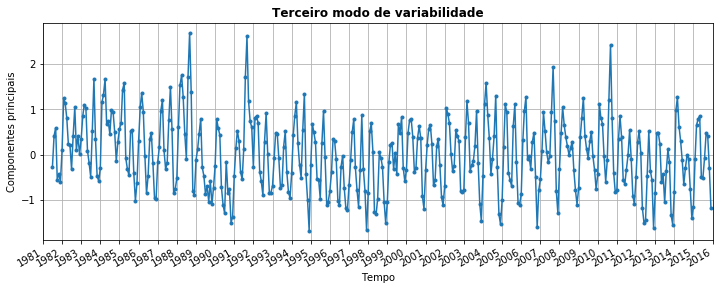

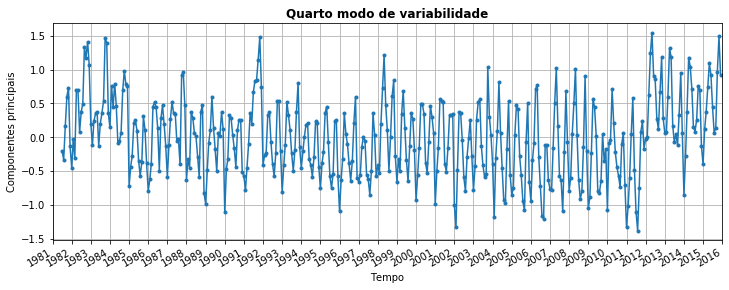

In [35]:
years = mdates.YearLocator()
years_fmt = mdates.DateFormatter("%Y")

# Plot some modes.
for mode, order, clim in zip(range(4), 
                             ["Primeiro", "Segundo", "Terceiro", "Quarto"], 
                             [(-0.05, 0.05), (-0.05, 0.05), (-0.05, 0.05), (-0.05, 0.05)]):

    # Make figure.
    plt.figure(figsize=(12, 4))

    ax = plt.subplot(1, 1, 1)
    PCs.sel(mode=mode).plot(marker=".", ax=ax)
    ax.set_xlim(pd.Timestamp("1981"), pd.Timestamp("2016"))
    ax.set_xticks(pd.date_range(start="1981", end="2016", freq="2YS"))
    ax.xaxis.set_major_locator(years)
    ax.xaxis.set_major_formatter(years_fmt)                             
    ax.grid()
    
    ax.set_xlabel("Tempo")
    ax.set_ylabel("Componentes principais")
    ax.set_title(order + " modo de variabilidade", weight="bold")

    # Save figure.
#     plt.savefig(fig_path + "ndvi_mode" + str(mode + 1) + "_pc_pt.jpg", dpi=200, 
#                 bbox_inches="tight")

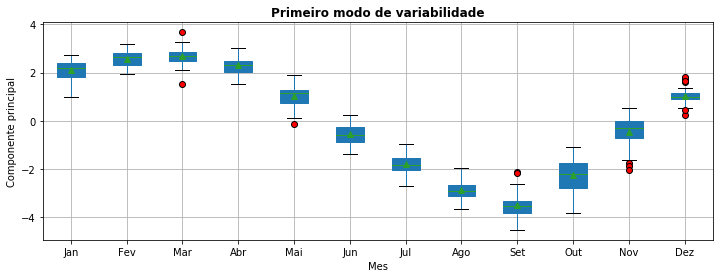

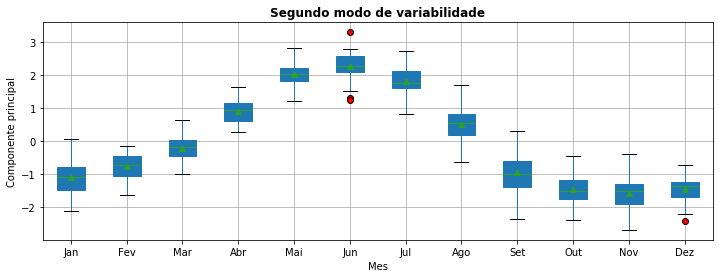

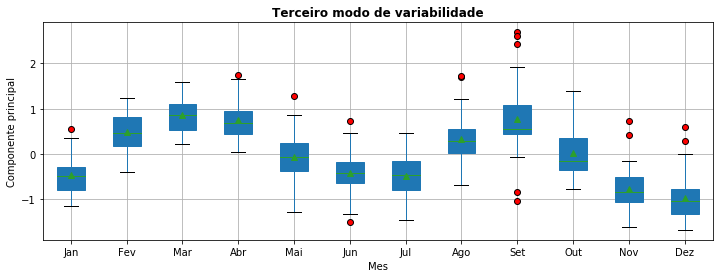

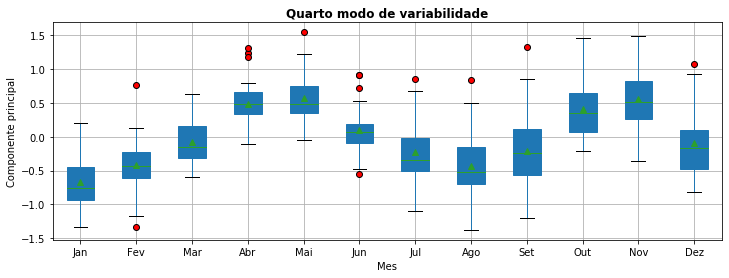

In [36]:
# Monthly box plots for principal components time series.
for mode, order in zip(range(4), ["Primeiro", "Segundo", "Terceiro", "Quarto"]):

    plt.figure(figsize=(12, 4))
    ax = plt.gca()
    df = PCs.sel(mode=mode).to_dataframe()
    df = pd.pivot_table(df, index=df.index.year, columns=df.index.month, values="pcs") 
    df.columns = ["Jan", "Fev", "Mar", "Abr", "Mai", "Jun", 
                  "Jul", "Ago", "Set", "Out", "Nov", "Dez"]
    df.boxplot(ax=ax, patch_artist=True, showmeans=True, 
               flierprops={"markerfacecolor": "red", "marker": "o"})
    plt.xlabel("Mes")
    plt.ylabel("Componente principal")
    plt.title(order + " modo de variabilidade", weight="bold")
    
    # Save figure.
#     plt.savefig(fig_path + "ndvi_mode" + str(mode + 1) + "_pc_boxplot_pt.jpg", dpi=200, 
#                 bbox_inches="tight")

In [37]:
# Reconstructed data for the first four modes.
rec = 4
F = solver.reconstructedField(rec) + DAr.mean("time").values

In [38]:
# Extract data as numpy array.
F_mm = F.groupby("time.month").mean("time")
DATA_rec = F_mm.values

# Original and reconstructed.
ORI = DATA.reshape((-1, ))
REC = DATA_rec.reshape((-1, ))

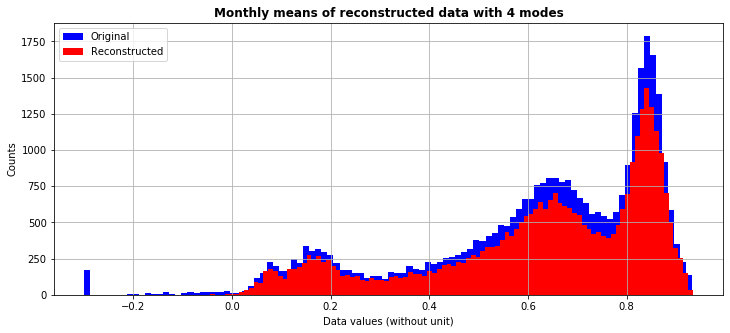

In [39]:
# Histogram of reconstructed monthly means.
plt.figure(figsize=(12, 5))
plt.hist(ORI, bins=100, color="blue", label="Original")
plt.hist(REC, bins=100, color="red", label="Reconstructed")
plt.title(f"Monthly means of reconstructed data with {rec} modes", weight="bold")
plt.xlabel("Data values (without unit)")
plt.ylabel("Counts")
plt.legend()
plt.grid();

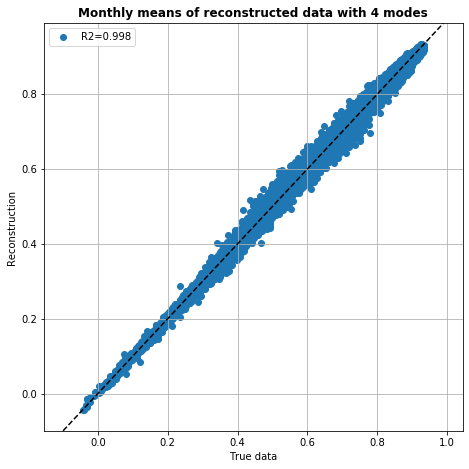

In [40]:
# Mask excluding np.nans for R2 calculation.
m1 = np.logical_not(np.isnan(ORI))
m2 = np.logical_not(np.isnan(REC))
mask = np.logical_and(m1, m2)

# Scatter plot of reconstruction.
plt.figure(figsize=(7.5, 7.5))
plt.scatter(ORI, REC, label=str("R2=%.3f" %r2_score(ORI[mask], REC[mask])))
plt.xlim()
p = plt.gca().get_xlim()
plt.plot(p, p, "k--")
plt.ylim(*p)
plt.title(f"Monthly means of reconstructed data with {rec} modes", weight="bold")
plt.xlabel("True data")
plt.ylabel("Reconstruction")
plt.legend()
plt.grid();

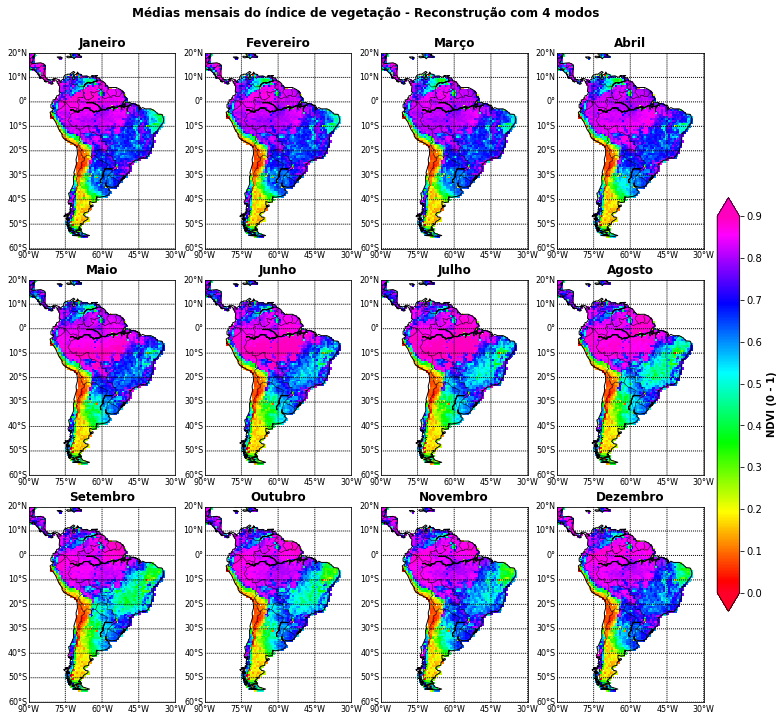

In [41]:
# Make figure.
cdlearn.maps.regional_scalar_monthly_means(DATA_rec, LON, LAT, loni, lonf, lati, latf, 
                                           clim=(0, 0.9), cmap=plt.cm.gist_rainbow, 
                                           months_labels=cdlearn.utils.months_labels_pt,
                                           title="Médias mensais do índice de vegetação - " + 
                                           "Reconstrução com " + str(rec) + " modos",
                                           clabel="NDVI (0 - 1)", fig_size=(12.5, 11.5), 
                                           save_fig=False, fig_path=fig_path, 
                                           fig_name="ndvi_mmeans_rec" + str(rec) + "_pt")

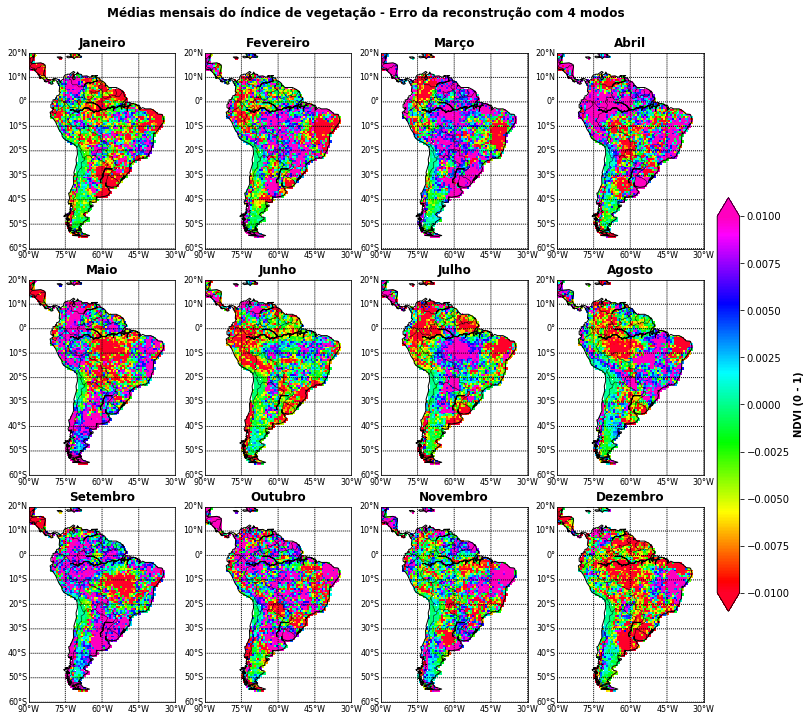

In [42]:
# Make figure.
cdlearn.maps.regional_scalar_monthly_means(DATA - DATA_rec, LON, LAT, loni, lonf, lati, latf, 
                                           clim=(-0.01, 0.01), cmap=plt.cm.gist_rainbow, 
                                           months_labels=cdlearn.utils.months_labels_pt,
                                           title="Médias mensais do índice de vegetação - " + 
                                           "Erro da reconstrução com " + str(rec) + " modos",
                                           clabel="NDVI (0 - 1)", fig_size=(12.5, 11.5), 
                                           save_fig=False, fig_path=fig_path, 
                                           fig_name="ndvi_mmeans_rec_err" + str(rec) + "_pt")